In [1]:
from collections import Counter
import random

import joblib
import numpy as np
import pandas as pd

from data_manipulation.reading_util import load_all_sub_classes
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import os
from dotenv import load_dotenv
from data_manipulation.reading_util import load_non_enz_esm2
from metrics_helper_funcs.validation_tools import plot_bootstrapped_score, plot_confiusion_matrix, calculate_micro_f1, calculate_accuracy, calculate_macro_f1, calculate_weighted_f1

load_dotenv()



2023-11-24 10:25:00.496867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 10:25:01.592833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

In [2]:
comp_ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}

comp_label_to_ec = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10_20_23_97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2_9_19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3_7_8_9_11_13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99_7_5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6_7_99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5_4_6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3_4_5_6" ,
}


In [3]:
# Random level 2 pred
def random_level_0(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_0_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)


In [4]:
# Random level 2 pred
def random_level_2(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/y_train_subclass_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)

    # count_dict = Counter(comp_label_to_ec.keys())
    # print(count_dict)
    # predictions = []

    # for key in count_dict.keys():
    #     count_dict[key] /= len(y)
    # print(count_dict)

    # for _ in y:
    #     predicted_label = random.choices(list(count_dict.keys()), weights=count_dict.values())[0]
    #     predictions.append(predicted_label)
    # 
    # return np.array(predictions)



In [5]:
def validate_on_test_data_v1(path_to_test_csv: str, path_to_test_esm2: str,
                          path_to_non_ez_fasta: str, path_to_non_ez_esm2: str,
                          path_to_multiclass_model, path_to_binaryclass_model):

    print("\n\n\t\t\t\033[34m[ LOADING DATA AND MODELS ]\033[0m\n\n\t\t\t")
    # Load model and test data
    multiclass_model = tf.keras.models.load_model(path_to_multiclass_model)
    binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)

    # Load RF
    # binaryclass_model =  joblib.load(path_to_binaryclass_model)
    # df=pd.read_csv("/home/malte/Desktop/Dataset/Test_Data/test_set_df_for_rf_reduced_pca.csv")


    X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2=path_to_test_esm2, path_to_enzyme_csv=path_to_test_csv, allowed_labels=comp_ec_to_label)

    # Load non_enzymes
    X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=path_to_non_ez_fasta,
                                         non_enzymes_esm2_path=path_to_non_ez_esm2)
    del _
    y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])

    # X_non_enzymes = X_non_enzymes[:1000] 
    # y_non_enzymes = y_non_enzymes[:1000] 

    # Combine data
    X_binary = np.vstack((X_enzymes, X_non_enzymes))
    y_binary = [1 for _ in y_enzymes]
    y_binary.extend(y_non_enzymes)
    y_binary = np.array(y_binary)

    del y_non_enzymes
    del X_non_enzymes
    # Plot input data
    y_sorted = y_enzymes.copy()
    y_sorted.sort()


    y_ec_classes = [comp_label_to_ec[label] for label in y_sorted if label != 0]

    print("\n\n\t\t\t\033[34m[ PLOTTING INPUT DISTRIBUTION ]\033[0m\n\n\t\t\t")
    
    sns.set()
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set(font_scale=0.8)  # Adjust font size as needed

    countplot = sns.countplot(x=y_binary)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

    # Add labels and title
    plt.title("Preprocessed labels for multiclass FNN")
    plt.xlabel("Labels")
    plt.ylabel("Count")

    # Show the plot
    plt.show()

    sns.set()
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set(font_scale=0.8)  # Adjust font size as needed

    countplot = sns.countplot(x=y_ec_classes)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

    # Add labels and title
    plt.title("Preprocessed labels for multiclass FNN")
    plt.xlabel("Labels")
    plt.ylabel("Count")

    # Show the plot
    plt.show()

    print("\n\n\t\t\t\033[34m[ MAKING PREDICTIONS ]\033[0m\n\n\t\t\t")


    level_0_pred = binaryclass_model.predict(X_binary) > 0.5
    level_2_pred = np.argmax(multiclass_model.predict(X_enzymes), axis=-1)

    print("\n\n\t\t\t\033[34m[ REPORT FNN LEVEl 0]\033[0m\n\n\t\t\t")
    report = classification_report(y_binary, level_0_pred)
    print(report)
    
    print("\n\n\t\t\t\033[34m[ REPORT FNN LEVEL 2]\033[0m\n\n\t\t\t")
    report = classification_report(y_enzymes, level_2_pred)
    print(report)
    print(y_enzymes[:10])
    print(level_2_pred[:10])


    print("\n\n\t\t\t\033[34m[ MAKING BASELINE PREDICTION ]\033[0m\n\n\t\t\t")

    random_baseline_level_0_pred = random_level_0(y_binary)
    random_baseline_level_2_pred = random_level_2(y_enzymes)



    print("\n\n\t\t\t\033[34m[ REPORT RANDOM BASELINE LEVEL 0]\033[0m\n\n\t\t\t")

    print(classification_report(y_binary, random_baseline_level_0_pred))
    
    print("\n\n\t\t\t\033[34m[ REPORT RANDOM BASELINE LEVEL 2]\033[0m\n\n\t\t\t")

    print(classification_report(y_enzymes, random_baseline_level_2_pred))


    print("\n\n\t\t\t\033[34m[ PLOTTING CONFUSION MATRIX ]\033[0m\n\n\t\t\t")

    plot_confiusion_matrix(y_true=y_binary, y_pred=level_0_pred, plot_title="Level 0 FNN", lable_size=10)
    # plot_confiusion_matrix(y_true=y_enzymes, y_pred=level_2_pred, plot_title="Level 2 FNN", hide_inner_labels=True, lable_size=10)

    plot_confiusion_matrix(y_true=y_binary, y_pred=random_baseline_level_0_pred, plot_title="Level 0 BASELINE", lable_size=10)
    # plot_confiusion_matrix(y_true=y_enzymes, y_pred=random_baseline_level_2_pred, plot_title="Level 2 BASELINE", hide_inner_labels=True, lable_size=10)

    print("\n\n\t\t\t\033[34m[ PLOTTING SCORES ]\033[0m\n\n\t\t\t")

    plot_bootstrapped_score(y_trues=[y_binary, y_binary, y_enzymes, y_enzymes], y_preds=[level_0_pred, random_baseline_level_0_pred,level_2_pred, random_baseline_level_2_pred], scoring_funcs=[calculate_micro_f1,calculate_macro_f1, calculate_weighted_f1, calculate_accuracy], model_names=["FNN Level 0","Baseline Level 0", "FNN Level 2", "Baseline Level 2"])


In [6]:
def validate_on_test_data(path_to_test_csv: str, path_to_test_esm2: str, 
                          path_to_non_ez_fasta: str, path_to_non_ez_esm2: str, 
                          path_to_multiclass_model, path_to_binaryclass_model):

    print("\n\n\t\t\t\033[34m[ LOADING DATA AND MODELS ]\033[0m\n\n\t\t\t")
    # Load model and test data
    multiclass__model = tf.keras.models.load_model(path_to_multiclass_model)
    binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)
    
    # Load RF
    # binaryclass_model =  joblib.load(path_to_binaryclass_model)
    # df=pd.read_csv("/home/malte/Desktop/Dataset/Test_Data/test_set_df_for_rf_reduced_pca.csv")


    X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2=path_to_test_esm2, path_to_enzyme_csv=path_to_test_csv, allowed_labels=comp_ec_to_label)

    if not (path_to_non_ez_esm2 == None or path_to_non_ez_fasta == None):
        # Load non_enzymes
        X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=path_to_non_ez_fasta,
                                                         non_enzymes_esm2_path=path_to_non_ez_esm2)
        del _
        y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
        
        # X_non_enzymes = X_non_enzymes[:1000] 
        # y_non_enzymes = y_non_enzymes[:1000] 
        
        # Combine data
        X = np.vstack((X_enzymes, X_non_enzymes))
        y = np.hstack((y_enzymes, y_non_enzymes))

        del X_non_enzymes
        y_ec_classes = [0 for i in range(len(y_non_enzymes))]
        del y_non_enzymes
    else:
        X = X_enzymes
        y = y_enzymes
        y_ec_classes = []
        
    del X_enzymes
    del y_enzymes
    
    # Plot input data
    y_sorted = y.copy()
    y_sorted.sort()
    

    print("\n\n\t\t\t\033[34m[ PLOTTING INPUT DISTRIBUTION ]\033[0m\n\n\t\t\t")
    
    sns.set()
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set(font_scale=0.8)  # Adjust font size as needed

    countplot = sns.countplot(x=y_ec_classes)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

    # Add labels and title
    plt.title("Preprocessed labels for multiclass FNN")
    plt.xlabel("Labels")
    plt.ylabel("Count")

    # Show the plot
    plt.show()

    print("\n\n\t\t\t\033[34m[ MAKING PREDICTIONS ]\033[0m\n\n\t\t\t")

    complete_predictions = []
    complete_y_true = []

    binary_predictions = binaryclass_model.predict(X) > 0.5

    X_to_predict_multiclass = []
    y_multiclass_true = []

    for index, prediction in enumerate((binary_predictions).astype(int)):
        if prediction == 1:
            X_to_predict_multiclass.append(X[index])
            y_multiclass_true.append(y[index])
        else:
            complete_predictions.append(int(prediction))
            complete_y_true.append(y[index])




    # Get multiclass predictions
    y_multiclass_pred = np.argmax(multiclass__model.predict(np.array(X_to_predict_multiclass)), axis=-1)
    y_multiclass_pred = [label+1 for label in y_multiclass_pred]
    complete_predictions.extend(y_multiclass_pred)
    complete_predictions = np.array(complete_predictions) # convert to np array
    y_pred = complete_predictions

    # Correctly concatenate actual labels for validation
    complete_y_true.extend(y_multiclass_true)
    y_true = complete_y_true
    y_true = np.array(y_true) # convert to np array

    report = classification_report(y_true, y_pred)
    print("\n\n\t\t\t\033[34m[ REPORT FNN ]\033[0m\n\n\t\t\t")
    
    print(report)


    print("\n\n\t\t\t\033[34m[ MAKING BASELINE PREDICTION ]\033[0m\n\n\t\t\t")
    
    random_baseline_binary_predictions = np.random.choice(y, len(y)) # 10454
    
    y_multiclass_random_true = []
    complete_random_predictions = []
    complete_y_true_random = []

    for index, prediction in enumerate(random_baseline_binary_predictions.astype(int)):
        if prediction == 1:
            # append actual label for every instance where random thinks it saw an enzyme
            y_multiclass_random_true.append(y[index]) 
        else:
            complete_random_predictions.append(int(prediction)) # append 0 to all random pred
            complete_y_true_random.append(y[index])
            
    # get random multiclass predictions
    y_random_predictions_multiclass = random_level_2(y_multiclass_random_true)
    # y_random_predictions_multiclass = [label+1 for label in y_random_predictions_multiclass]
    complete_random_predictions.extend(y_random_predictions_multiclass)
    complete_random_predictions = np.array(complete_random_predictions) # all predictions (Binary and multiclass)
    y_pred_random = complete_random_predictions
    
    # concatenate y_true
    complete_y_true_random.extend(y_multiclass_random_true)
    y_true_random = np.array(complete_y_true_random) # all actual labels for validation

    print("\n\n\t\t\t\033[34m[ REPORT RANDOM BASELINE ]\033[0m\n\n\t\t\t")
    
    print(classification_report(y_true_random, y_pred_random))
    
   
    print("\n\n\t\t\t\033[34m[ PLOTTING CONFUSION MATRIX ]\033[0m\n\n\t\t\t")

    plot_confiusion_matrix(y_true=y_true, y_pred=y_pred, plot_title="Level 2 FNN", hide_inner_labels=True, lable_size=10)
    plot_confiusion_matrix(y_true=y_true_random, y_pred=y_pred_random, plot_title="Level 2 Random Baseline",hide_inner_labels=True, lable_size=10)

    print("\n\n\t\t\t\033[34m[ PLOTTING SCORES ]\033[0m\n\n\t\t\t")

    plot_bootstrapped_score(y_trues=[y_true, y_true_random], y_preds=[y_pred, y_pred_random], scoring_funcs=[calculate_micro_f1,calculate_macro_f1, calculate_weighted_f1, calculate_accuracy], model_names=["FNN Pipeline Level 2", "Random Baseline Level 2"])

    print("\n\n\t\t\t\033[34m[ LEVEL 1 PERFORMANCE ]\033[0m\n\n\t\t\t")

    y_true_main_class_labels = []
    y_pred_main_class_labels = []
    
    for y_true, y_pred in zip(y_multiclass_true, y_multiclass_pred):
        if y_pred != 0 and y_true != 0: # we only want enzyme predictions
            y_true_main_class = int(comp_label_to_ec[y_true].split(".")[0])
            y_pred_main_class = int(comp_label_to_ec[y_pred].split(".")[0])
            y_true_main_class_labels.append(y_true_main_class)
            y_pred_main_class_labels.append(y_pred_main_class)
            
    
    # Convert the lists to NumPy arrays
    y_true_main_class_labels = np.array(y_true_main_class_labels)
    y_pred_main_class_labels = np.array(y_pred_main_class_labels)

    class_names = [1, 2, 3, 4, 5, 6, 7]
    conf_matrix = confusion_matrix(y_true_main_class_labels, y_pred_main_class_labels)
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_percent = (conf_matrix.T / row_sums).T * 100

    # Calculate the percentages
    cm_percentage = (conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]) * 100
    cm_percentage = cm_percentage.round(2)


    # Create a ConfusionMatrixDisplay without labels
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=class_names)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    cmd.plot(cmap="binary", ax=ax)
    cax = ax

    # Add the percentages as text annotations in the squares with specified ha and va
    for i in range(7):
        for j in range(7):

            # Increase the vertical offset for the percentage text
            offset = 0.4
            text_color = cax.texts[i * 7 + j].get_color()
            # ax.text(j, i - offset, f'{float(cm_percentage[i, j])}%', ha='center', va='top', color=text_color,  fontsize=8, fontweight='light', zorder=4)
            ax.text(j, i - offset, f"# {conf_matrix[i, j]}", ha='center', va='top', color=text_color, fontsize=8, fontweight='light', zorder=4)

    # Set the x and y labels
    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("Actual", fontsize=12)
    ax.grid(False)
    plt.title("Level 1 Performance")
    plt.show()
    
    report = classification_report(y_true_main_class_labels, y_pred_main_class_labels)
    print(report)
    
    plot_bootstrapped_score(y_trues=[y_true_main_class_labels], y_preds=[y_pred_main_class_labels], scoring_funcs=[calculate_micro_f1,calculate_macro_f1, calculate_weighted_f1, calculate_accuracy], model_names=["FNN Pipeline Level 1"])


In [7]:
bin_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/cnn_binary_opt_S30_v2_default_sampled_weighted.keras"

# bin_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/random_forest/random_forest_esm2.joblib"


mul_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/CNN_S30_weighted_opt_v2.keras"

emb_path = os.getenv("TEST_ESM2_ENZYMES")
csv_path = os.getenv("TEST_CSV_ENZYMES")

fasta_path = os.getenv("TEST_FASTA_NON_ENZYMES")
emb_non_ez_path = os.getenv("TEST_ESM2_NON_ENZYMES")



			[ LOADING DATA AND MODELS ]

			
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 entries will be ignored
LOG:
 Data loaded in: 0.087 min
LOG:
 ESM2 of enzymes: 578
LOG:
 Labels of enzymes: 578
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta
LOG:
 3 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta
LOG:
 538 non enzymes are longer than 1022 cutoff
LOG:
 541 entries will be ignored
LOG:
 Non Enzymes data loaded in: 1.095 min
LOG:
 ESM2 of non enzymes: 9876
LOG:
 Labels of non enzymes: 9876


			[ PLOTTING INPUT DISTRIBUTION ]

			


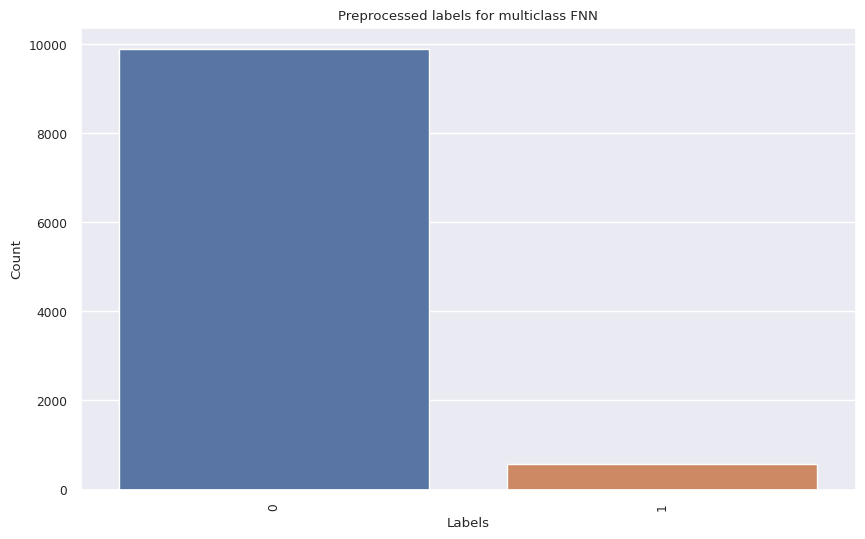

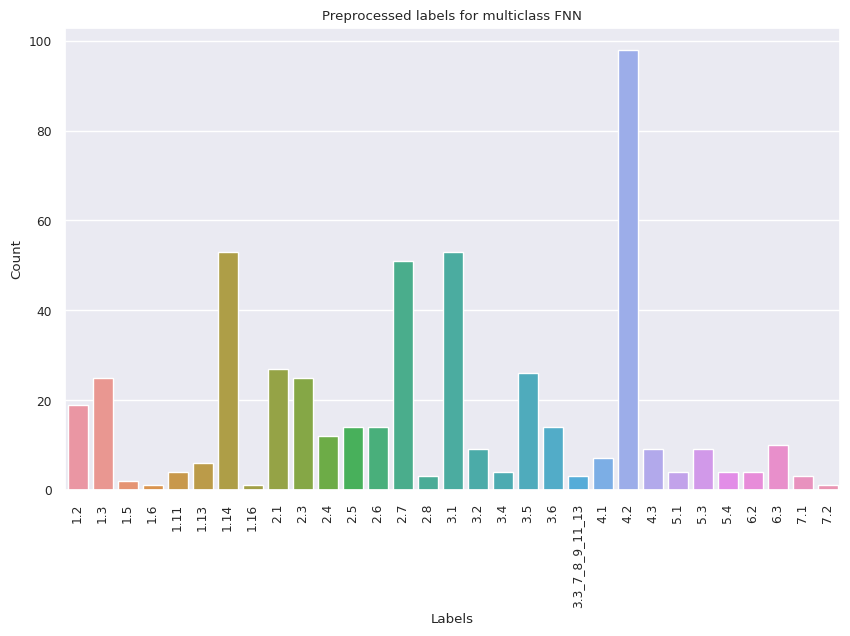



			[ MAKING PREDICTIONS ]

			
19/19 [==============================] - 0s 3ms/step


			[ REPORT FNN LEVEl 0]

			
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      9876
           1       0.42      0.97      0.59       578

    accuracy                           0.92     10454
   macro avg       0.71      0.95      0.77     10454
weighted avg       0.97      0.92      0.94     10454



			[ REPORT FNN LEVEL 2]

			
              precision    recall  f1-score   support

           0       0.97      0.60      0.75        63
           1       1.00      0.95      0.97        19
           2       0.71      0.96      0.81        25
           3       0.00      0.00      0.00         0
           4       1.00      1.00      1.00         2
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         4
          10       0.45      0.83   

/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/malte/.local/lib/python3.10/site-packages/

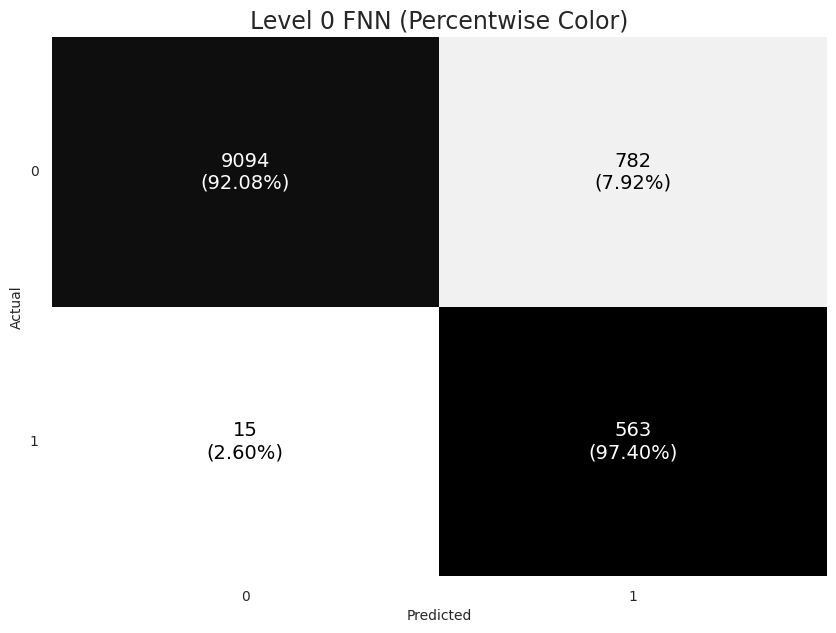

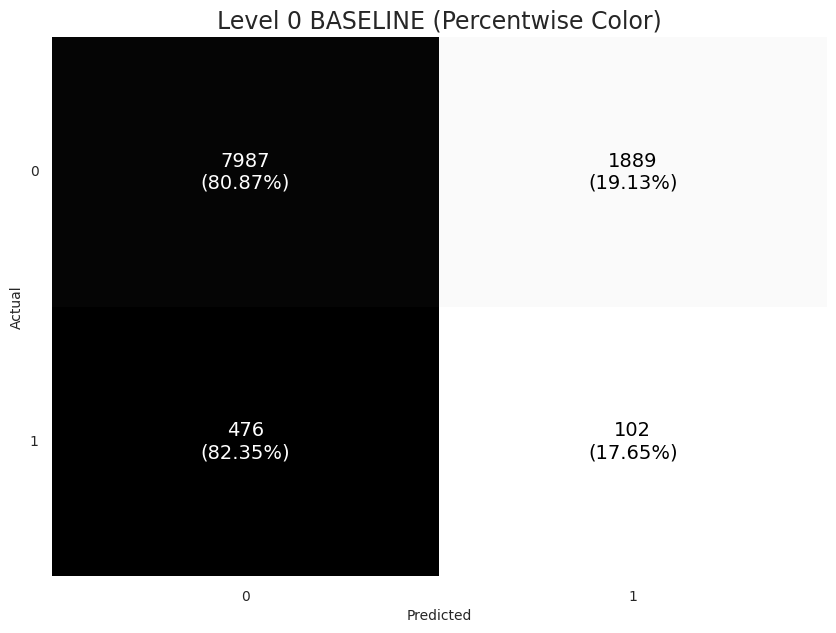



			[ PLOTTING SCORES ]

			
              Model             Metric  Mean Score      SE      CI_0      CI_1
0       FNN Level 0     Micro F1-Score       0.924  0.0026  0.918787  0.928831
1       FNN Level 0     Macro F1-Score       0.772  0.0071  0.757690  0.785468
2       FNN Level 0  Weighted F1-Score       0.937  0.0019  0.933776  0.941192
3       FNN Level 0           Accuracy       0.924  0.0026  0.918596  0.928735
0  Baseline Level 0     Micro F1-Score       0.774  0.0042  0.765449  0.782093
1  Baseline Level 0     Macro F1-Score       0.475  0.0042  0.467270  0.483607
2  Baseline Level 0  Weighted F1-Score       0.827  0.0035  0.820344  0.834055
3  Baseline Level 0           Accuracy       0.774  0.0040  0.765927  0.781806
0       FNN Level 2     Micro F1-Score       0.800  0.0170  0.762976  0.830450
1       FNN Level 2     Macro F1-Score       0.590  0.0300  0.537280  0.656449
2       FNN Level 2  Weighted F1-Score       0.810  0.0170  0.774822  0.841130
3       FNN Level 2   

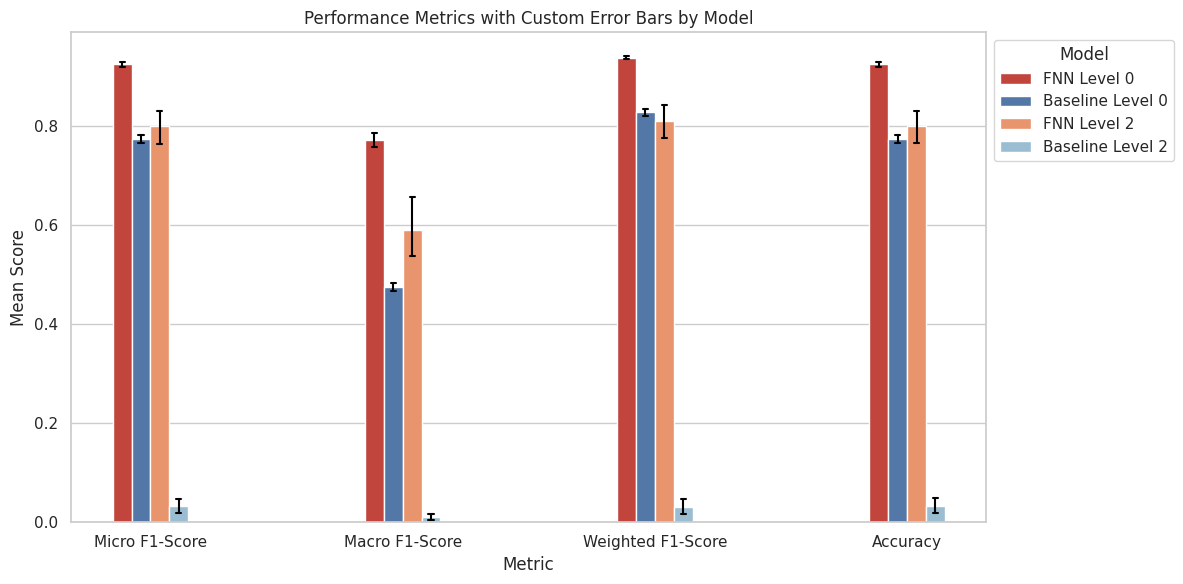

In [8]:
validate_on_test_data_v1(path_to_test_csv=csv_path,
                         path_to_test_esm2=emb_path,
                         path_to_non_ez_esm2=emb_non_ez_path,
                         path_to_non_ez_fasta=fasta_path,
                         path_to_binaryclass_model=bin_class_path,
                         path_to_multiclass_model=mul_class_path)